# Evaluation of unbiased word embeddings on GLUE (General Language Understanding Evaluation) benchmark

This notebook is adapted from [BERT_GLUE](https://www.tensorflow.org/text/tutorials/bert_glue), a tutorial made by Tensorflow to solve GLUE task using BERT-based models. We modify the preprocessing and the classifier in order to any use word embeddings based models. We also solve some bugs introduced by keras updates.


## Description of the tasks :

1. [2] [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability): Is the sentence grammatically correct?

1. [3] [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank): The task is to predict the sentiment of a given sentence.

1. [4] [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus): Determine whether a pair of sentences are semantically equivalent.

1. [5] [QQP](https://www.kaggle.com/c/quora-question-pairs) (Quora Question Pairs2): Determine whether a pair of questions are semantically equivalent.

1. [6] [MNLI](http://www.nyu.edu/projects/bowman/multinli/) (Multi-Genre Natural Language Inference): Given a premise sentence and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis (entailment), contradicts the hypothesis (contradiction), or neither (neutral).

1. [1, 7] [QNLI](https://rajpurkar.github.io/SQuAD-explorer/)(Question-answering Natural Language Inference): The task is to determine whether the context sentence contains the answer to the question.

1. [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment)(Recognizing Textual Entailment): Determine if a sentence entails a given hypothesis or not.

1. [8] [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html)(Winograd Natural Language Inference): The task is to predict if the sentence with the pronoun substituted is entailed by the original sentence.

## Description of the embeddings : 

We are using 300D embeddings from :

*   [9]  [GloVe](https://nlp.stanford.edu/projects/glove/) Global Vectors for Word Representation from Stanford. Trained on Wikipedia and Gigaword with 6 billion tokens. Has a vocabulary size of 400000 tokens. 
*   [10] [GN GloVe](https://arxiv.org/abs/1809.01496) Learning Gender-Neutral Word Embeddings trained on wikipedia with 1 billion tokens. Has a representation for 142527 words. The embeddings contain a gender-neutral component and a gender-biased one.
*   [11] [Word2vec](https://code.google.com/archive/p/word2vec/) from Google. Trained on 100 billions tokens from Google News. Has embeddings for 300 millions of tokens.  
*   [12] [Debiaswe](https://github.com/tolga-b/debiaswe) Hard-unbiased version of Word2Vec for which gender-neutral words were neutralized and equalized.






We recommend to run this notebook on a TPU or a GPU.

In this notebook, you will:

- Choose an embedding.
- Choose one of GLUE tasks and download the dataset
- Preprocess the text
- Fine-tune a model

## Setup


In [ ]:
!pip install -U tfds-nightly

In [ ]:
import os

import gensim
import gensim.downloader

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import *

import numpy as np

tf.get_logger().setLevel('ERROR')

In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [ ]:
if 'COLAB_TPU_ADDR' in os.environ:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  print('Running on CPU is not recommended.')

# Loading Dataset

We define functions to load and preprocess our data. 

- `preprocess_model` creates a model which vectorizes every input with the same vectorizer and concatenates them. It is especially useful when the input is a pair of sentences.

- `load_dataset_from_tfds` loads the data in a tensorflow Dataset, adapts the vectorizer and uses the preprocessing model on every sentence. Iterating through its output returns a pair of `(preprocessed input, label)`.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_model(sentence_features, vectorizer):
  input_segments = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)for ft in sentence_features]
  # Tokenize the text to word pieces.
  
  segments = [vectorizer(s) for s in input_segments]
  concatenate_layer = Concatenate()
  concatenate = hub.KerasLayer(concatenate_layer, name='concatenate')
  model_inputs = concatenate(segments)
  return tf.keras.Model(input_segments, model_inputs)


def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           sentence_features, vectorizer):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    # Adapt the vectorizer (learn the vocabulary)
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
    L = []
    for s in sentence_features:
      L.append(in_memory_ds[split][s])
    vectorizer.adapt(np.array(L).flatten())
    del L

  preprocesser = preprocess_model(sentence_features, vectorizer)

  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (preprocesser(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples



## Load embeddings


This section is dedicated to downloading pre-trained embeddings which we will test later. 

For models using word2vec, we load the models using `gensim` and store their vocabulary in `word2vec_vocab`. For other embeddings, we load them directly in a dictionnary `{word : vector}`.

**You can add any embedding by simply downloading them in a `.txt` format, and add their path in `paths`**

In [ ]:
embedding_model = "Unbiased_GloVe" #@param ['GloVe_Stanford', 'Unbiased_GloVe', 'Unbiased_Word2Vec', 'Word2Vec']

paths = {
    "GloVe_Stanford" : "glove.6B.300d.txt",
    "Unbiased_GloVe" : "1b-vectors300-0.8-0.8.txt",
    "Unbiased_Word2Vec" : "GoogleNews-vectors-negative300-hard-debiased.bin.gz", 
    'Word2Vec' : None # Downloaded directly from gensim
}


In [ ]:
# Download the embeddings

if embedding_model == "GloVe_Stanford" :
  if not os.path.exists(paths['GloVe_Stanford']) :
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

elif embedding_model == 'Unbiased_GloVe':
  # gender neutral glove from https://github.com/uclanlp/gn_glove
  if not os.path.exists(paths['Unbiased_GloVe']):
    !sudo wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g1QPqbIlQorwlfGShtPbZVk6mfwodQgE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g1QPqbIlQorwlfGShtPbZVk6mfwodQgE" -O 1b-GNGloVe-300d-0.8-0.8.zip && rm -rf /tmp/cookies.txt
    !unzip -q 1b-GNGloVe-300d-0.8-0.8.zip

elif embedding_model == 'Unbiased_Word2Vec':
  # https://github.com/tolga-b/debiaswe
  if not os.path.exists(paths['Unbiased_Word2Vec']) : 
    !sudo wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5vZVlu2WoS5ZTBSekpUX0RSNDg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B5vZVlu2WoS5ZTBSekpUX0RSNDg" -O GoogleNews-vectors-negative300-hard-debiased.bin.gz && rm -rf /tmp/cookies.txt
  word2vec = gensim.models.KeyedVectors.load_word2vec_format(paths['Unbiased_Word2Vec'], binary=True)
  word2vec_vocab = word2vec.wv.vocab

elif embedding_model == 'Word2Vec':
  word2vec = gensim.downloader.load("word2vec-google-news-300")
  word2vec_vocab = word2vec.wv.vocab
  
else :
  raise ValueError("Pick a model among ['GloVe_Stanford', 'Unbiased_GloVe', 'Unbiased_Word2Vec', 'Word2Vec']")


In [ ]:
# Load non Word2Vec models

if "Word2Vec" not in embedding_model :
  path_to_embedding = paths[embedding_model]

  embeddings_index = {}
  with open(path_to_embedding) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs

  print("Found %s word vectors." % len(embeddings_index))

## Define your model

We use a model composed of two LSTM layers with 64 units followed by a TimeDistributed Dense layer and a 2 layers MLP. This model provides decent performances and a tolerable training time.

In [ ]:
def build_classifier_model(num_classes, word_index, voc):

  # -------------------- Build the Embedding Layer --------------------
  num_tokens = len(voc) + 2  # Vocabulary contains 2 special tokens "padding" and "OOV" (Out of Vocabulary)
  embedding_dim = 300
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))


  # If Word2Vec is used, get the embeddings from gensim
  if "Word2Vec" in embedding_model : 
    for word, i in word_index.items():
        if word in word2vec_vocab:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = word2vec[word]
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
  
  else :
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

  embedding_layer = Embedding(num_tokens,
                              embedding_dim,
                              embeddings_initializer=Constant(embedding_matrix),
                              trainable=False) # The embeddings should not be trained
  
  # -------------------- Build the classifier with the embedding layer --------------------

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):      
      super(Classifier, self).__init__(name="prediction")
      self.encoder = embedding_layer
      self.lstm1 = Bidirectional(LSTM(64, return_sequences = True, dropout = 0.25))
      self.lstm2 = Bidirectional(LSTM(64, return_sequences = True, dropout = 0.25))
      self.dropout1 = Dropout(0.2)
      self.dense1 = TimeDistributed(Dense(128, activation = 'relu'))
      self.flatten = Flatten()
      self.dropout2 = Dropout(0.2)
      self.dense2 = Dense(128, activation = 'relu')
      self.dropout3 = Dropout(0.2)
      self.dense3 = Dense(num_classes, activation = 'softmax')

    def call(self, preprocessed_text):
      x = self.encoder(preprocessed_text)
      x = self.lstm1(x)
      x = self.lstm2(x)
      x = self.dropout1(x)
      x = self.dense1(x)
      x = self.flatten(x)
      x = self.dropout2(x)
      x = self.dense2(x)
      x = self.dropout3(x)
      x = self.dense3(x)
      return x
  


  model = Classifier(num_classes)
  return model

## Choose a task from GLUE

A description of every dataset and the metrics used to evaluate these models offered in the original paper [1]. We do not evaluate our models on the mismatched MNLI test set.

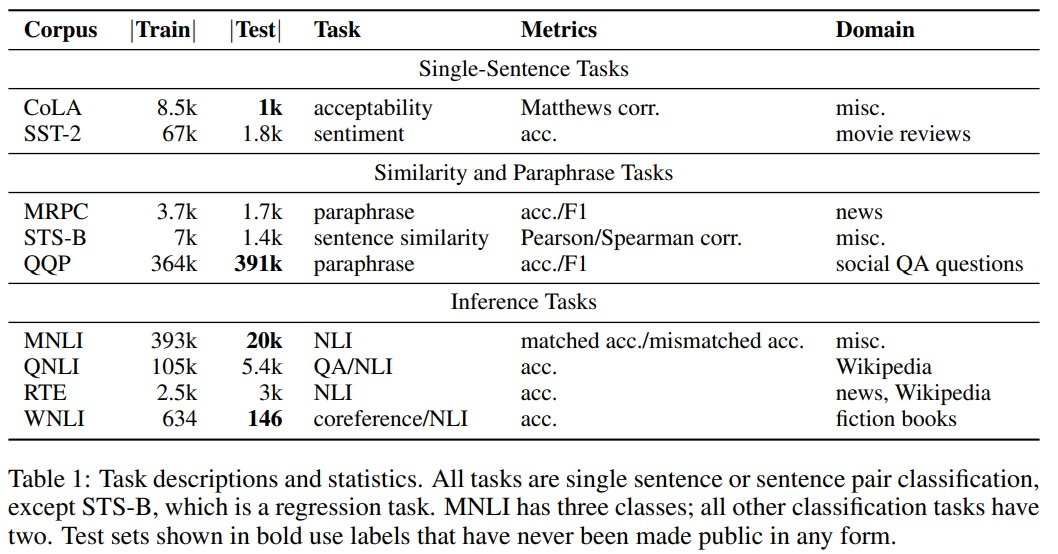

In [ ]:
tfds_name = 'glue/wnli'  #@param ['glue/cola', 'glue/sst2', 'glue/mrpc', 'glue/qqp', 'glue/mnli', 'glue/qnli', 'glue/rte', 'glue/wnli']

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

The dataset also determines the problem type (classification or regression).

## Train your model

Finally, you can train the model end-to-end on the dataset you chose. 


In [ ]:
epochs = 3
batch_size = 32
output_sequence_length = 200    # Length of every sentence vector. A sentence with less than 200 words will be padded. A sentence with more will be cut.

with strategy.scope():

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)  
  metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)


  vectorizer = TextVectorization(max_tokens=20000, 
                                  output_sequence_length = output_sequence_length, 
                                  ngrams = 2)
  # The vectorize will lowercase every word, remove punctuation, split the sentence into tokens, index every token and transform the sentence into a sequence of integers.  


  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, 
      sentence_features, vectorizer)             
  # The vectorizer is adapted in the previous function call

  validation_dataset, validation_data_size = load_dataset_from_tfds(  
      in_memory_ds, tfds_info, validation_split, batch_size,
      sentence_features, vectorizer)   
  # The adapted vectorizer is used to preprocess the training data    


  voc = vectorizer.get_vocabulary()
  word_index = dict(zip(voc, range(len(voc))))
  # The vocabulary is required in order to build the embedding layer of our classifier                                 

  classifier_model = build_classifier_model(num_classes, word_index, voc)            
  classifier_model.compile(optimizer="adam", loss=loss, metrics=[metrics]) 

  steps_per_epoch = train_data_size // batch_size
  validation_steps = validation_data_size // batch_size

  classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

## Evaluate the model


How well is our model performing on the validation dataset ? 

This function returns the loss and every metric that we have chosen. In our case, it returns `[loss, accuracy]`. You can try other metrics but be careful when using keras' metrics as we met issues with many of them.

In [ ]:
classifier_model.evaluate(validation_dataset, batch_size = batch_size)

### Distribution of the data 

We plot the distribution of the data to see how well our model works against a random classifier. Some of the tasks are unbalanced an the accuracy is not a good way to evaluate the performances. 


In [ ]:
import matplotlib.pyplot as plt

res = []
for input, y in validation_dataset:
  res.append(y)
y_true = tf.concat(res, 0)

plt.hist(y_true, bins = num_classes * 2)
plt.show()

### MCC
For cola, the MCC (matthews correlation coefficient) is more appropriate than the accuracy.


In [ ]:
y_true = tf.concat(res, 0)
y_true_casted = tf.cast(y_true, tf.float32)

y_pred = classifier_model.predict(validation_dataset)
predicted = tf.cast(tf.math.argmax(y_pred, axis = 1), tf.float32)
true_pos = tf.math.count_nonzero(predicted * y_true_casted)
true_neg = tf.math.count_nonzero((predicted - 1) * (y_true_casted - 1))
false_pos = tf.math.count_nonzero(predicted * (y_true_casted - 1))
false_neg = tf.math.count_nonzero((predicted - 1) * y_true_casted)


def mcc_metric_eval(true_pos, true_neg, false_pos, false_neg):
    x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
        * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
    return (tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)).numpy()

mcc_metric_eval(true_pos, true_neg, false_pos, false_neg)

### F1Score 
For MRPC and QQP, the F1Score is a recommended metric.

In [ ]:
def f1_score_eval(true_pos, true_neg, false_pos, false_neg):
    precision = tf.cast(true_pos / (true_pos + false_pos), tf.float32)
    recall = tf.cast(true_pos / (true_pos + false_neg), tf.float32)
    return (2 * precision * recall / (precision + recall)).numpy()

f1_score_eval(true_pos, true_neg, false_pos, false_neg)

# References



[1] A. Wang, A. Singh, J. Michael, F. Hill, O. Levy, and S. R. Bowman, “Glue: A multi-task
benchmark and analysis platform for natural language understanding,” arXiv preprint
arXiv:1804.07461, 2018.
1

[2] A. Warstadt, A. Singh, and S. R. Bowman, “Neural network acceptability judgments,”
arXiv preprint arXiv:1805.12471, 2018.
1

[3] R. Socher, A. Perelygin, J. Wu, J. Chuang, C. D. Manning, A. Y. Ng, and C. Potts,
“Recursive deep models for semantic compositionality over a sentiment treebank,” in
Proceedings of the 2013 conference on empirical methods in natural language processing,
2013, pp. 1631–1642.
1


[4] B. Dolan and C. Brockett, “Automatically constructing a corpus of sentential para-
phrases,” in Third International Workshop on Paraphrasing (IWP2005), 2005.
1

[5] Z. Wang, W. Hamza, and R. Florian, “Bilateral multi-perspective matching for natural
language sentences,” arXiv preprint arXiv:1702.03814, 2017.
1

[6] A. Williams, N. Nangia, and S. Bowman, “A broad-coverage challenge corpus for sentence
understanding through inference,” in Proceedings of the 2018 Conference of the North
American Chapter of the Association for Computational Linguistics: Human Language
Technologies, Volume 1 (Long Papers). Association for Computational Linguistics,
2018, pp. 1112–1122. [Online]. Available: http://aclweb.org/anthology/N18-1101
1

[7] P. Rajpurkar, J. Zhang, K. Lopyrev, and P. Liang, “Squad: 100,000+ questions for
machine comprehension of text,” arXiv preprint arXiv:1606.05250, 2016.

[8] H. Levesque, E. Davis, and L. Morgenstern, “The winograd schema challenge,” in Thir-
teenth international conference on the principles of knowledge representation and reason-
ing, 2012

[9] Pennington, J., Socher, R., & Manning, C. D. (2014, October). Glove: Global vectors for word representation. In Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP) (pp. 1532-1543).

[10] Zhao, J., Zhou, Y., Li, Z., Wang, W., & Chang, K. W. (2018). Learning gender-neutral word embeddings. arXiv preprint arXiv:1809.01496.

[11] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.

[12] Bolukbasi, T., Chang, K. W., Zou, J. Y., Saligrama, V., & Kalai, A. T. (2016). Man is to computer programmer as woman is to homemaker? debiasing word embeddings. Advances in neural information processing systems, 29.
